The Games-Howell test is a nonparametric [post hoc analysis](https://en.wikipedia.org/wiki/Post_hoc_analysis) approach for performing [multiple comparisons](https://en.wikipedia.org/wiki/Multiple_comparisons_problem) for two or more sample populations. The Games-Howell test is somewhat similar to [Tukey's post hoc test](https://aaronschlegel.me/tukeys-test-post-hoc-analysis.html). Still, unlike Tukey's test, it does not assume homogeneity of variances or equal sample sizes. Thus, the Games-Howell test can be applied in settings when the assumptions of Tukey's test do not hold. The Games-Howell test and Tukey's test will often report similar results with data that is assumed to have equal variance and equal sample sizes.

Games-Howell test employs the [Welch-Satterthwaite equation for degrees of freedom](https://en.wikipedia.org/wiki/Welch%E2%80%93Satterthwaite_equation), which is also known as the pooled degrees of freedom and is based on Tukey's studentized range distribution, denoted $q$. As the Games-Howell test is nonparametric, it uses the ranks of the observations rather than the raw sample observation values.

The Games-Howell test is defined as:

$$ \bar{x}_i - \bar{x}_j > q_{\sigma, k, df} $$

Where $\sigma$ is equal to standard error:

$$ \sigma = \sqrt{{\frac{1}{2} \left(\frac{s^2_i}{n_i} + \frac{s^2_j}{n_j}\right)}} $$

Degrees of freedom is calculated using Welch's correction:

$$ \large \frac{\left(\frac{s^2_i}{n_i} + 
\frac{s^2_j}{n_j}\right)^2}{\frac{\left(\frac{s_i^2}{n_i}\right)^2}{n_i - 1} +
\frac{\left(\frac{s_j^2}{n_j}\right)^2}{n_j - 1}} $$

Thus, confidence intervals can be formed with:

$$ \bar{x}_i - \bar{x}_j \pm t \sqrt{{\frac{1}{2} \left(\frac{s_i^2}{n_i} + \frac{s_j^2}{n_j}\right)}} $$

p-values are calculated using Tukey's studentized range:

$$ \large q_{t * \sqrt{2}, k, df} $$

### Games-Howell Test in Python

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import numpy_indexed as npi
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.libqsturng import qsturng, psturng
from hypothetical.descriptive import var
from itertools import combinations

For this example, we will perform the Games-Howell test on the [InsectSprays](https://stat.ethz.ch/R-manual/R-patched/library/datasets/html/InsectSprays.html) dataset, a standard dataset available in [R](https://www.r-project.org/). The dataset can be downloaded as a CSV [here](https://vincentarelbundock.github.io/Rdatasets/csv/datasets/InsectSprays.csv). According to the [dataset's description](https://stat.ethz.ch/R-manual/R-patched/library/datasets/html/InsectSprays.html), there are two columns:

* Count of insects
* Type of insecticide spray used.

Before beginning, we load the data using `pandas`'s [`read_csv`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) and inspect it to confirm the columns and data are what is described. After loading the data, we convert it to a `numpy` array using the [`.to_numpy`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_numpy.html) method. The first three rows of the array are then displayed as well as the unique values in the insecticide spray column.

In [2]:
sprays = pd.read_csv('../../data/InsectSprays.csv')
sprays = sprays.to_numpy()

print(sprays[:3])
print(list(np.unique(sprays[:,2])))

[[1 10 'A']
 [2 7 'A']
 [3 20 'A']]
['A', 'B', 'C', 'D', 'E', 'F']


The array contains the two data columns as expected, including an index column that is added when the data is loaded by `pandas`. We also see there are six types of insecticide sprays used in the experiment. A boxplot of the dataset is plotted using [`seaborn`](https://seaborn.pydata.org/index.html) to get a better sense of the distribution of the groups.

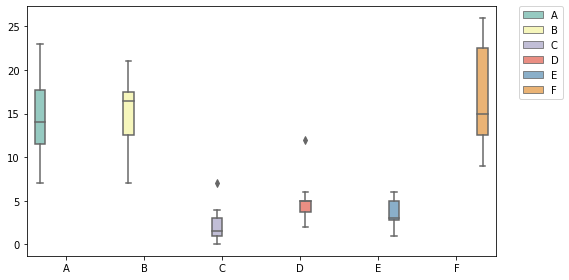

In [3]:
plt.figure(figsize=(8, 4))

box = sns.boxplot(x=sprays[:,2], y=sprays[:,1], hue=sprays[:,2], palette="Set3")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()

The boxplot shows the groups' distributions and variances are slightly different from each other. Therefore, the Games-Howell test is a good candidate for comparing the groups as it does not assume equality of variances. We first find the total number of groups, $k$, as well as the group means, observations, and variance. The [`combinations`](https://docs.python.org/2/library/itertools.html#itertools.combinations) function from Python's `itertools` library is used to get all possible combinations of groups. The $\alpha$ used in this example is $0.05$.

In [4]:
alpha = 0.05
k = len(np.unique(sprays[:,2]))

group_means = dict(npi.group_by(sprays[:, 2], sprays[:, 1], np.mean))
group_obs = dict(npi.group_by(sprays[:, 2], sprays[:, 1], len))
group_variance = dict(npi.group_by(sprays[:, 2], sprays[:, 1], var))

combs = list(combinations(np.unique(sprays[:, 2]), 2))
combs

[('A', 'B'),
 ('A', 'C'),
 ('A', 'D'),
 ('A', 'E'),
 ('A', 'F'),
 ('B', 'C'),
 ('B', 'D'),
 ('B', 'E'),
 ('B', 'F'),
 ('C', 'D'),
 ('C', 'E'),
 ('C', 'F'),
 ('D', 'E'),
 ('D', 'F'),
 ('E', 'F')]

With the computed group descriptive statistics in hand, we can proceed to implement the Games-Howell test. The following block loops through each set of combinations listed above and calculates the mean difference, t-value, degrees of freedom, and p-value defined by the Games-Howell test. The `psturng` and `qsturng` functions from the [`statsmodels.stats.libqsturng`](https://github.com/statsmodels/statsmodels/tree/master/statsmodels/stats/libqsturng) module of the [statsmodels](https://www.statsmodels.org/stable/index.html) library are used for Tukey's studentized range cumulative distribution function and quantile function, respectively.

In [5]:
group_comps = []
mean_differences = []
degrees_freedom = []
t_values = []
p_values = []
std_err = []
up_conf = []
low_conf = []

for comb in combs:
    # Mean differences of each group combination
    diff = group_means[comb[1]] - group_means[comb[0]]
    
    # t-value of each group combination
    t_val = np.abs(diff) / np.sqrt((group_variance[comb[0]] / group_obs[comb[0]]) + 
                                   (group_variance[comb[1]] / group_obs[comb[1]]))
    
    # Numerator of the Welch-Satterthwaite equation
    df_num = (group_variance[comb[0]] / group_obs[comb[0]] + group_variance[comb[1]] / group_obs[comb[1]]) ** 2
    
    # Denominator of the Welch-Satterthwaite equation
    df_denom = ((group_variance[comb[0]] / group_obs[comb[0]]) ** 2 / (group_obs[comb[0]] - 1) +
                (group_variance[comb[1]] / group_obs[comb[1]]) ** 2 / (group_obs[comb[1]] - 1))
    
    # Degrees of freedom
    df = df_num / df_denom
    
    # p-value of the group comparison
    p_val = psturng(t_val * np.sqrt(2), k, df)

    # Standard error of each group combination
    se = np.sqrt(0.5 * (group_variance[comb[0]] / group_obs[comb[0]] + 
                        group_variance[comb[1]] / group_obs[comb[1]]))
    
    # Upper and lower confidence intervals
    upper_conf = diff + qsturng(1 - alpha, k, df)
    lower_conf = diff - qsturng(1 - alpha, k, df)
    
    # Append the computed values to their respective lists.
    mean_differences.append(diff)
    degrees_freedom.append(df)
    t_values.append(t_val)
    p_values.append(p_val)
    std_err.append(se)
    up_conf.append(upper_conf)
    low_conf.append(lower_conf)
    group_comps.append(str(comb[0]) + ' : ' + str(comb[1]))

The appended lists from the iteration above are then grouped into a `pandas`'s [`DataFrame`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) to give us a quick and nice table display of the multiple comparisons computed by the Games-Howell test.

In [6]:
result_df = pd.DataFrame({'groups': group_comps,
                          'mean_difference': mean_differences,
                          'std_error': std_err,
                          't_value': t_values,
                          'p_value': p_values,
                          'upper_limit': up_conf,
                          'lower limit': low_conf})

result_df

,groups,mean_difference,std_error,t_value,p_value,upper_limit,lower limit
0,A : B,0.833333,1.299281,0.453524,0.900000,5.242928,-3.576261
1,A : C,-12.416667,1.044315,8.407339,0.001000,-7.810592,-17.022741
2,A : D,-9.583333,1.090449,6.214359,0.001000,-5.050736,-14.115931
3,A : E,-11.000000,1.026173,7.579791,0.001000,-6.356537,-15.643463
4,A : F,2.166667,1.592676,0.961944,0.900000,6.600972,-2.267639
5,B : C,-13.250000,0.960554,9.753917,0.001000,-8.674351,-17.825649
6,B : D,-10.416667,1.010519,7.289021,0.001000,-5.915312,-14.918021
7,B : E,-11.833333,0.940798,8.893970,0.001000,-7.217952,-16.448715
8,B : F,1.333333,1.539054,0.612590,0.900000,5.790263,-3.123596
9,C : D,2.833333,0.650854,3.078215,0.055715,7.260483,-1.593816


Let's filter the table to only group comparisons with a p-value below $0.05$.

In [7]:
result_df.loc[result_df['p_value'] <= 0.05]

,groups,mean_difference,std_error,t_value,p_value,upper_limit,lower limit
1,A : C,-12.416667,1.044315,8.407339,0.001,-7.810592,-17.022741
2,A : D,-9.583333,1.090449,6.214359,0.001,-5.050736,-14.115931
3,A : E,-11.000000,1.026173,7.579791,0.001,-6.356537,-15.643463
5,B : C,-13.250000,0.960554,9.753917,0.001,-8.674351,-17.825649
6,B : D,-10.416667,1.010519,7.289021,0.001,-5.915312,-14.918021
7,B : E,-11.833333,0.940798,8.893970,0.001,-7.217952,-16.448715
11,C : F,14.583333,1.330845,7.748440,0.001,19.262776,9.903890
13,D : F,11.750000,1.367346,6.076375,0.001,16.367352,7.132648
14,E : F,13.166667,1.316657,7.071119,0.001,17.874228,8.459105


### References

Ruxton, G.D., and Beauchamp, G. (2008) 'Time for some a priori thinking about post hoc testing',
    Behavioral Ecology, 19(3), pp. 690-693. doi: 10.1093/beheco/arn020.
    In-text citations: (Ruxton and Beauchamp, 2008)
    
Post-hoc (no date) Available at: http://www.unt.edu/rss/class/Jon/ISSS_SC/Module009/isss_m91_onewayanova/node7.html